# `credible_regions.py`

This notebook tests the `credible_regions` module.

This module contains the methods FIGARO uses to determine the 1-, 2- and 3-D credible regions.

## `FindNearest`

This function returns the indices of the closest 3D grid point to the passed ra, dec, dist values (the coordinates of the true host).
The printed values are the distances of the selected grid point and its neighbors from the true host divided by the grid spacing.

In [1]:
import numpy as np
from figaro.credible_regions import FindNearest

dmax = 100

ra   = np.linspace(0,2*np.pi, 720)
dra  = ra[1]-ra[0]
dec  = np.linspace(-np.pi/2, np.pi/2., 360)
ddec = dec[1]-dec[0]
dist = np.linspace(0, dmax, 100)
dD   = dist[1]-dist[0]

true_host = np.array([np.random.uniform(0,2*np.pi), np.random.uniform(-np.pi/2., np.pi/2.), np.random.uniform(0, dmax)])

idx = FindNearest(ra, dec, dist, true_host)

for i, (var, ar, diff) in enumerate(zip(['RA: ', 'dec:', 'DL: '], [ra, dec, dist], [dra, ddec, dD])):
    print(var, abs(ar[np.array([idx[i]-1, idx[i], idx[i]+1])] - true_host[i])/diff)

RA:  [1.23767751 0.23767751 0.76232249]
dec: [1.37520775 0.37520775 0.62479225]
DL:  [0.97640155 0.02359845 1.02359845]


## `FindHeights`

This method returns the probability value associated with a certain credible level.\
It is meant to work with multidimensional distributions, for which a prescription is required to get the cdf: ours is to sort the probability bins in decreasing order and carry out the integration accordingly. Therefore, the logpdf passed to `FindHeight` must be in decreasing order, and the logcdf must be obtained according to our convention.

We will test the method with a 1D standard Gaussian distribution.

In [2]:
from scipy.stats import norm
from figaro.credible_regions import FindHeights

# https://en.wikipedia.org/wiki/68–95–99.7_rule#Table_of_numerical_values
level_1sigma = 0.6827
level_2sigma = 0.9545
level_3sigma = 0.9973

levels = [level_1sigma, level_2sigma, level_3sigma]

x  = np.linspace(-5,5,10000)
dx = x[1]-x[0]

p        = norm().pdf(x)*dx
sorted_p = np.sort(p)[::-1]
cdf      = np.cumsum(sorted_p)

logpdf = np.log(sorted_p)
logcdf = np.log(cdf)

for i, l in enumerate(levels):
    print('{0}-sigma:'.format(i+1), x[np.where(np.log(p) == FindHeights((logpdf, logcdf, l)))])

1-sigma: [-0.99959996  0.99959996]
2-sigma: [-1.99969997  1.99969997]
3-sigma: [-2.99979998  2.99979998]


## `FindHeightForLevel`

This method finds the probability value associated with a certain credible level. Differently from `FindHeights`, the cdf is computed by the method itself.\
As above, it is tested with the standard Gaussian distribution.

In [3]:
from figaro.credible_regions import FindHeightForLevel

logP = norm().logpdf(x)
hs   = FindHeightForLevel(logP, levels, np.log(dx))

for i, h in enumerate(hs):
    print('{0}-sigma:'.format(i+1), x[np.where(logP == h)])

1-sigma: [-0.99959996  0.99959996]
2-sigma: [-1.99969997  1.99969997]
3-sigma: [2.99979998]


For 2D standard Gaussian distribution, the level corresponding to $n$-sigma is:\
$
L = \int_0^{2\pi}\int_0^n \frac{r}{2\pi}e^{-r^2/2}dr d\theta = 1 - e^{-n^2/2} \,.
$

1-sigma: 0.9998937837936026
2-sigma: 2.0000107303959265
3-sigma: 2.9999068008181355


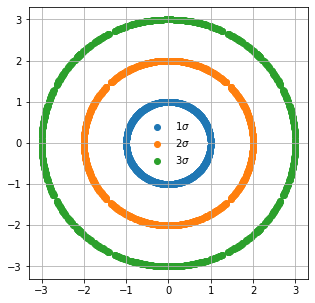

In [4]:
from scipy.stats import multivariate_normal as mn
import matplotlib.pyplot as plt

def compute_L(n):
    return 1-np.exp(-n**2/2.)

# Make grid
y = np.linspace(-4,4,2000)
z = np.linspace(-4,4,2000)
dy = y[1]-y[0]
dz = z[1]-z[0]

grid = []
for yi in y:
    for zi in z:
        grid.append([yi,zi])
grid = np.array(grid)

# Compute heights
logP_2d = mn(np.zeros(2), np.identity(2)).logpdf(grid)
L       = compute_L(np.array([1,2,3]))

hs = FindHeightForLevel(logP_2d, L, np.log(dy)+np.log(dz))

# Make plot
fig = plt.figure(figsize = (5,5))
ax  = fig.add_subplot(111)

for i, h in enumerate(hs):
    pts  = grid[np.where(np.isclose(logP_2d, h, atol = 1e-3, rtol = 0))]
    dist = np.sqrt(np.mean(np.sum(pts**2, axis = 1)))
    print('{0}-sigma:'.format(i+1), dist)
    ax.scatter(pts[:,0], pts[:,1], label = '${0}\\sigma$'.format(i+1))

ax.legend(loc=0, frameon=False)
ax.grid()

## `FindLevelForHeight`

This module does the inverse of the previous one, finding the credible level corresponding to a certain probability value.\
The following example computes the credible levels for 1, 2 and 3 sigmas of the 1D standard Gaussian:

In [5]:
from figaro.credible_regions import FindLevelForHeight

hs = norm().logpdf(np.array([1,2,3]))

for i, (h, l) in enumerate(zip(hs, levels)):
    print('{0}-sigma: FIGARO {1:.4f}, expected {2}'.format(i+1, FindLevelForHeight(logP, h, np.log(dx)), l))

1-sigma: FIGARO 0.6825, expected 0.6827
2-sigma: FIGARO 0.9545, expected 0.9545
3-sigma: FIGARO 0.9973, expected 0.9973


Same with the 2D standard Gaussian:

In [6]:
hs = mn(np.zeros(2), np.identity(2)).logpdf(np.array([[0,1], [0,2], [0,3]]))

for i, (h, l) in enumerate(zip(hs, L)):
    print('{0}-sigma: FIGARO {1:.4f}, expected {2:.4f}'.format(i+1, FindLevelForHeight(logP_2d, h, np.log(dy)+np.log(dz)), l))

1-sigma: FIGARO 0.3935, expected 0.3935
2-sigma: FIGARO 0.8647, expected 0.8647
3-sigma: FIGARO 0.9889, expected 0.9889


## `ConfidenceVolume`

This module computes the volume enclosed within a certain credible level. This method is meant to work with skymaps, therefore it requires celestial coordinates.

Let's test this module with the 3D standard Gaussian distribution. 

The volume within the n-$\sigma$ credible region is $\frac{4}{3}\pi n^3$.

In [7]:
from figaro.credible_regions import ConfidenceVolume
from figaro.coordinates import celestial_to_cartesian

from scipy.special import erf
def compute_L_3d(n):
    return erf(n/np.sqrt(2)) - np.sqrt(2/np.pi)*n*np.exp(-n**2/2.)

ra   = np.linspace(0,2*np.pi, 72, endpoint = False)
dra  = ra[1]-ra[0]
dec  = np.linspace(-np.pi/2, np.pi/2., 72)
ddec = dec[1]-dec[0]
dist = np.linspace(0, 5, 1001)[1:]
dD   = dist[1]-dist[0]

# For loops
grid = []
measure = []
for ra_i in ra:
    for dec_i in dec:
        for d_i in dist:
            grid.append(np.array([ra_i, dec_i, d_i]))
            measure.append(np.cos(dec_i)*d_i**2)
celestial_grid = np.array(grid)
measure = np.log(measure)

logP = mn(np.zeros(3), np.identity(3)).logpdf(celestial_to_cartesian(celestial_grid)) + np.log(3)
levels_3d = compute_L_3d(np.array([1, 2, 3]))
vols, idxs, heights = ConfidenceVolume(logP.reshape(len(ra), len(dec), len(dist)), ra, dec, dist, measure.reshape(len(ra), len(dec), len(dist)), levels_3d)

for i, v in enumerate(vols):
    print('{0}-sigma: FIGARO {1:.3f}, expected {2:.3f}'.format(i+1, v, 4*np.pi/3*(i+1)**3))

for i in range(len(vols)):
    grid_idx = []
    for idx in idxs[i]:
        grid_idx.append(idx[0]*len(dec)*len(dist)+idx[1]*len(dist)+idx[2])
    pts = celestial_grid[grid_idx]
    print('max R for {0}-sigma: {1}'.format(i+1, np.max(pts[:,2])))

1-sigma: FIGARO 4.220, expected 4.189
2-sigma: FIGARO 33.630, expected 33.510
3-sigma: FIGARO 113.212, expected 113.097
max R for 1-sigma: 1.0
max R for 2-sigma: 2.0
max R for 3-sigma: 3.0


## `ConfidenceArea`

This module computes the area enclosed within a certain credible region across a skymap.

We are testing this module using the uniform distribution and asking for the 100% credible region. In this situation, what we get is the whole sky area, in $\mathrm{deg}^2$.

In [8]:
from figaro.credible_regions import ConfidenceArea

ra   = np.linspace(0,2*np.pi, 720, endpoint = False)
dra  = ra[1]-ra[0]
dec  = np.linspace(-np.pi/2, np.pi/2., 720)
ddec = dec[1]-dec[0]


# For loops
grid = []
measure = []
for ra_i in ra:
    for dec_i in dec:
        grid.append(np.array([ra_i, dec_i]))
        measure.append(np.cos(dec_i))
grid_2d = np.array(grid)
measure_2d = np.log(measure)

sigma = 0.1
logP = np.zeros(len(grid))
levels_2d = [1e-100]

areas, idxs, heights = ConfidenceArea(logP.reshape(len(ra), len(dec)), ra, dec, measure_2d.reshape(len(ra), len(dec)), levels_2d)

for i, a in enumerate(areas):
    print('all-sky: FIGARO {1:.3f}, expected {2:.3f}'.format(i+1, a, 4*np.pi*(180/np.pi)**2))

all-sky: FIGARO 41252.896, expected 41252.961
